In [ ]:
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# import pmdarima as pm
# from pmdarima.arima import auto_arima

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests
import statsmodels.tsa.vector_ar.vecm as vecm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from prophet import Prophet
from prophet.diagnostics import cross_validation

from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 18, 8
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
dataset = pd.read_csv('HomeC.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [ ]:
dataset.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [ ]:
dataset.describe()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,5.255900e+04,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,...,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000
mean,1.451626e+09,1.008972,0.056110,1.008972,0.036696,0.209107,0.224410,0.088326,0.054439,0.019175,...,29.855717,0.625549,9.466746,23.551023,1015.663289,7.570922,219.384451,0.001705,18.071476,0.032157
std,5.698778e+06,0.676284,0.114554,0.676284,0.206529,0.216093,0.245923,0.106282,0.071220,0.035207,...,9.967898,0.144829,1.305794,12.328863,8.604147,4.209991,103.008399,0.009429,11.348945,0.133414
min,1.451677e+08,0.000033,0.000000,0.000033,0.000000,0.002433,0.002017,0.002467,0.000133,0.000217,...,4.910000,0.220000,0.830000,-8.540000,990.900000,0.090000,0.000000,0.000000,-5.380000,0.000000
25%,1.451638e+09,0.525537,0.003067,0.525537,0.000017,0.020833,0.064267,0.041150,0.005017,0.006800,...,22.630000,0.520000,9.640000,14.270000,1010.220000,4.490000,173.000000,0.000000,9.000000,0.000000
50%,1.451651e+09,0.885208,0.003367,0.885208,0.000067,0.071017,0.067383,0.042533,0.005333,0.007133,...,29.840000,0.610000,10.000000,23.950000,1015.190000,6.710000,247.000000,0.000000,18.670000,0.000000
75%,1.451664e+09,1.334446,0.033133,1.334446,0.000233,0.469883,0.440063,0.086267,0.121529,0.007433,...,36.580000,0.730000,10.000000,31.570000,1022.060000,10.010000,301.000000,0.000000,24.800000,0.000000
max,1.451677e+09,7.854933,0.554950,7.854933,1.378650,1.915517,0.775417,0.913317,0.851267,0.229633,...,56.360000,0.920000,10.000000,56.360000,1036.620000,22.810000,359.000000,0.129800,53.470000,0.810000


In [ ]:
dataset.isnull().sum()

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [ ]:
dataset.describe(include='all')

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
count,5.255900e+04,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,52558.000000,...,52558.000000,52558,52558.000000,52558.000000,52558.000000,52558.0,52558.000000,52558.000000,52558.000000,52558.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11,NaN,NaN,NaN,89.0,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Clear,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,41886,NaN,NaN,NaN,6032.0,NaN,NaN,NaN,NaN
mean,1.451626e+09,1.008972,0.056110,1.008972,0.036696,0.209107,0.224410,0.088326,0.054439,0.019175,...,9.466746,NaN,23.551023,1015.663289,7.570922,NaN,219.384451,0.001705,18.071476,0.032157
std,5.698778e+06,0.676284,0.114554,0.676284,0.206529,0.216093,0.245923,0.106282,0.071220,0.035207,...,1.305794,NaN,12.328863,8.604147,4.209991,NaN,103.008399,0.009429,11.348945,0.133414
min,1.451677e+08,0.000033,0.000000,0.000033,0.000000,0.002433,0.002017,0.002467,0.000133,0.000217,...,0.830000,NaN,-8.540000,990.900000,0.090000,NaN,0.000000,0.000000,-5.380000,0.000000
25%,1.451638e+09,0.525537,0.003067,0.525537,0.000017,0.020833,0.064267,0.041150,0.005017,0.006800,...,9.640000,NaN,14.270000,1010.220000,4.490000,NaN,173.000000,0.000000,9.000000,0.000000
50%,1.451651e+09,0.885208,0.003367,0.885208,0.000067,0.071017,0.067383,0.042533,0.005333,0.007133,...,10.000000,NaN,23.950000,1015.190000,6.710000,NaN,247.000000,0.000000,18.670000,0.000000
75%,1.451664e+09,1.334446,0.033133,1.334446,0.000233,0.469883,0.440063,0.086267,0.121529,0.007433,...,10.000000,NaN,31.570000,1022.060000,10.010000,NaN,301.000000,0.000000,24.800000,0.000000


In [ ]:
dataset.isna().sum()

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [ ]:
for col in dataset:
  dataset.nunique()
col

'precipProbability'

In [ ]:
dataset.shape

(52559, 32)

In [ ]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52559 entries, 0 to 52558
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 52559 non-null  int64  
 1   use [kW]             52558 non-null  float64
 2   gen [kW]             52558 non-null  float64
 3   House overall [kW]   52558 non-null  float64
 4   Dishwasher [kW]      52558 non-null  float64
 5   Furnace 1 [kW]       52558 non-null  float64
 6   Furnace 2 [kW]       52558 non-null  float64
 7   Home office [kW]     52558 non-null  float64
 8   Fridge [kW]          52558 non-null  float64
 9   Wine cellar [kW]     52558 non-null  float64
 10  Garage door [kW]     52558 non-null  float64
 11  Kitchen 12 [kW]      52558 non-null  float64
 12  Kitchen 14 [kW]      52558 non-null  float64
 13  Kitchen 38 [kW]      52558 non-null  float64
 14  Barn [kW]            52558 non-null  float64
 15  Well [kW]            52558 non-null 

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
52558,145167695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop the line with missing values
dataset.dropna(inplace=True)

In [ ]:
dataset.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [ ]:
# Check if there are entries with null values
display(dataset.info())
dataset[dataset.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52558 entries, 0 to 52557
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 52558 non-null  int64  
 1   use [kW]             52558 non-null  float64
 2   gen [kW]             52558 non-null  float64
 3   House overall [kW]   52558 non-null  float64
 4   Dishwasher [kW]      52558 non-null  float64
 5   Furnace 1 [kW]       52558 non-null  float64
 6   Furnace 2 [kW]       52558 non-null  float64
 7   Home office [kW]     52558 non-null  float64
 8   Fridge [kW]          52558 non-null  float64
 9   Wine cellar [kW]     52558 non-null  float64
 10  Garage door [kW]     52558 non-null  float64
 11  Kitchen 12 [kW]      52558 non-null  float64
 12  Kitchen 14 [kW]      52558 non-null  float64
 13  Kitchen 38 [kW]      52558 non-null  float64
 14  Barn [kW]            52558 non-null  float64
 15  Well [kW]            52558 non-null 

None

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability


In [ ]:
obj_cols = ['icon', 'summary', 'cloudCover']
for i in obj_cols:
    print(f'{i} takes the following unique values {dataset[i].unique()}')

icon takes the following unique values ['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind']
summary takes the following unique values ['Clear' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Drizzle' 'Light Rain'
 'Rain' 'Light Snow' 'Flurries' 'Breezy' 'Snow']
cloudCover takes the following unique values ['cloudCover' '0.75' '0' '1' '0.31' '0.44' '0.13' '0.19' '0.25' '0.16'
 '0.21' '0.15' '0.14' '0.27' '0.28' '0.17' '0.05' '0.1' '0.26' '0.29'
 '0.11' '0.09' '0.12' '0.06' '0.02' '0.08' '0.04' '0.35' '0.22' '0.23'
 '0.54' '0.39' '0.03' '0.07' '0.76' '0.62' '0.18' '0.79' '0.48' '0.24'
 '0.57' 0.24 1.0 0.31 0.28 0.15 0.41 0.1 0.12 0.08 0.09 0.19 0.04 0.05
 0.29 0.27 0.35 0.18 0.06 0.03 0.11 0.14 0.25 0.78 0.0 0.16 0.21 0.23 0.17
 0.75 0.26 0.2 0.76 0.13 0.77 0.46 0.07 0.55 0.02 0.01 0.51 0.47 0.5 0.4
 0.3 0.22 0.43 0.33 0.6]


In [ ]:
dataset[dataset['cloudCover']=='cloudCover'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57],
           dtype='int64')

In [ ]:
dataset['cloudCover'].replace('cloudCover', np.nan, inplace=True)
dataset['cloudCover'].fillna(method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')

In [ ]:
dataset.columns = [col.replace(' [kW]', '') for col in dataset.columns]
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Furnace 1',
       'Furnace 2', 'Home office', 'Fridge', 'Wine cellar', 'Garage door',
       'Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [ ]:
dataset['sum_Furnace'] = dataset[['Furnace 1','Furnace 2']].sum(axis=1)
dataset['avg_Kitchen'] = dataset[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)

In [ ]:
dataset = dataset.drop(['Kitchen 12','Kitchen 14','Kitchen 38'], axis=1)
dataset = dataset.drop(['Furnace 1','Furnace 2'], axis=1)
dataset.columns

Index(['time', 'use', 'gen', 'House overall', 'Dishwasher', 'Home office',
       'Fridge', 'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'sum_Furnace', 'avg_Kitchen'],
      dtype='object')

In [ ]:
dataset['time'].head()

0    1451624400
1    1451624401
2    1451624402
3    1451624403
4    1451624404
Name: time, dtype: int64

In [ ]:
import time 
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(dataset['time'].iloc[0]))))

 start  2016-01-01 05:00:00


In [ ]:
time_index = pd.date_range('2016-01-01 05:00', periods=len(dataset),  freq='min')  
time_index = pd.DatetimeIndex(time_index)
dataset = dataset.set_index(time_index)
dataset = dataset.drop(['time'], axis=1)
dataset.iloc[np.r_[0:5,-5:0]].iloc[:,0]

2016-01-01 05:00:00    0.932833
2016-01-01 05:01:00    0.934333
2016-01-01 05:02:00    0.931817
2016-01-01 05:03:00    1.022050
2016-01-01 05:04:00    1.139400
2016-02-06 16:53:00    0.249467
2016-02-06 16:54:00    0.024250
2016-02-06 16:55:00    0.008833
2016-02-06 16:56:00    0.045233
2016-02-06 16:57:00    0.027850
Name: use, dtype: float64

In [ ]:
dataset.shape

(52558, 28)

<AxesSubplot:>

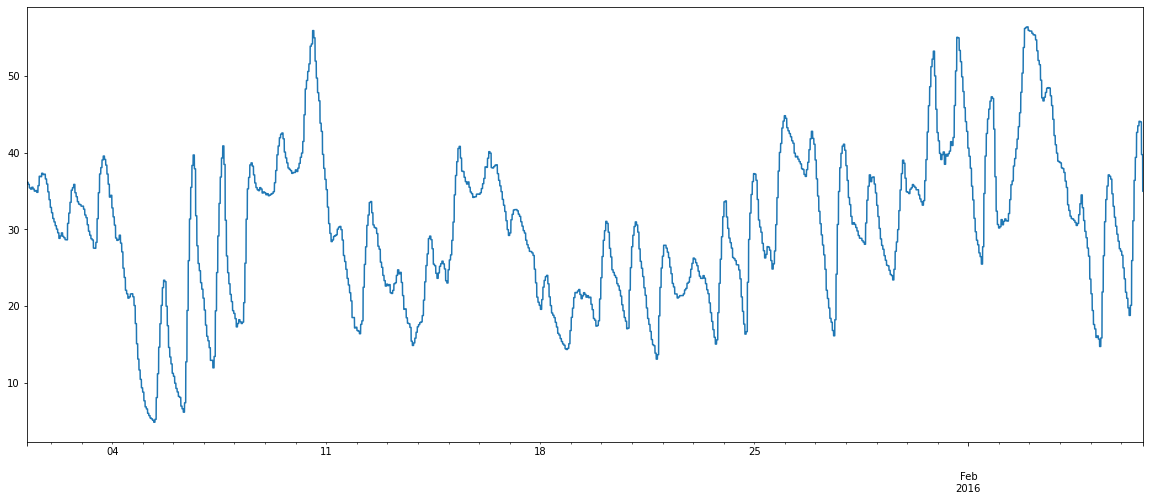

In [ ]:
dataset['temperature'].plot(figsize=(20,8))

<AxesSubplot:>

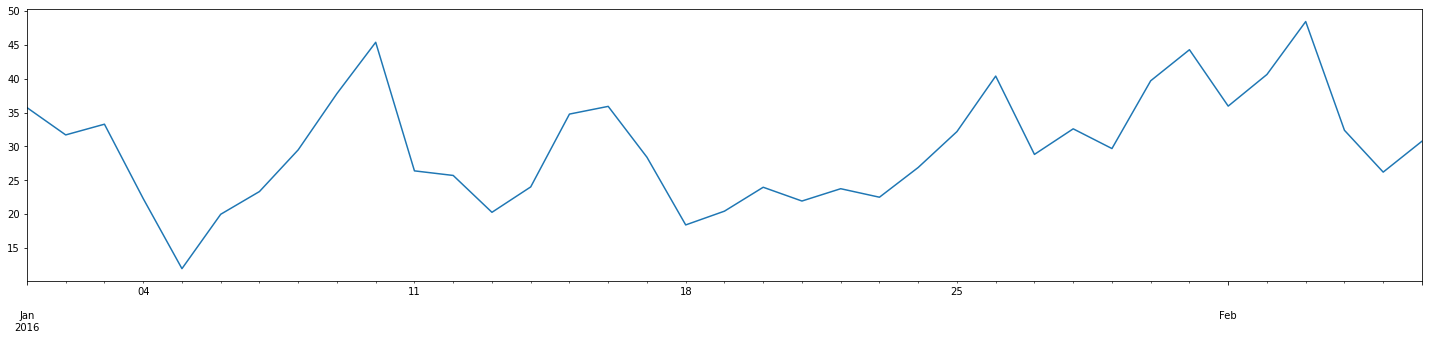

In [ ]:
dataset['temperature'].resample(rule='D').mean().plot(figsize=(25,5))

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)

<AxesSubplot:>

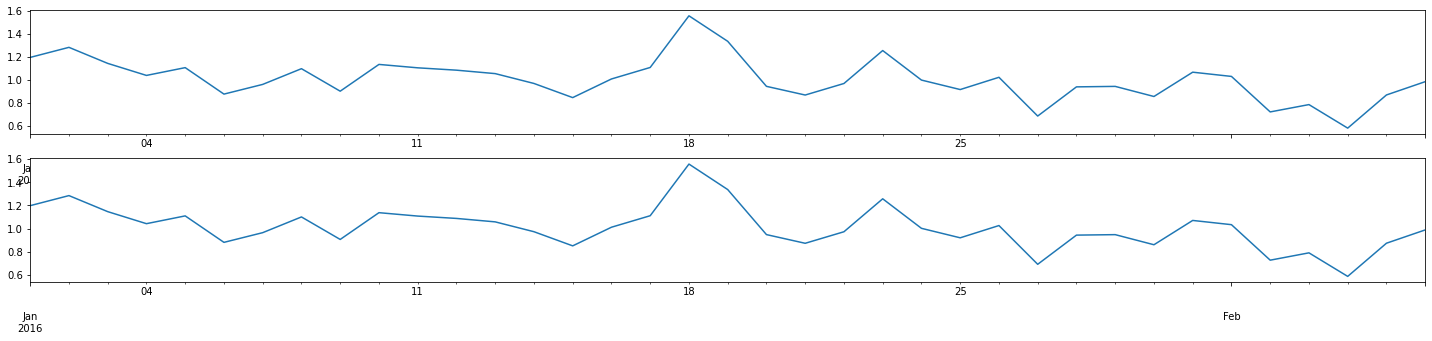

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
dataset['use'].resample('D').mean().plot(ax=axes[0])
dataset['House overall'].resample('D').mean().plot(ax=axes[1])

In [ ]:
# dataset = dataset.drop(columns=['House overall'])
# dataset.shape

In [ ]:
dataset['icon'].value_counts()

clear-night            25820
clear-day              16066
partly-cloudy-night     4582
partly-cloudy-day       2146
rain                    2146
snow                    1160
cloudy                   522
wind                     116
Name: icon, dtype: int64

In [ ]:
dataset = dataset.drop(columns=['summary', 'icon'])
dataset.shape

(52558, 26)

In [ ]:
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ])

In [ ]:
dataset['cloudCover'][56:60]

2016-01-01 05:56:00    0.75
2016-01-01 05:57:00    0.75
2016-01-01 05:58:00    0.75
2016-01-01 05:59:00    0.75
Freq: T, Name: cloudCover, dtype: float64

In [ ]:
dataset[dataset['cloudCover']=='cloudCover'].shape

(0, 26)

In [ ]:
dataset['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
dataset['cloudCover'] = dataset['cloudCover'].astype('float')
dataset['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ])

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52558 entries, 2016-01-01 05:00:00 to 2016-02-06 16:57:00
Freq: T
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   use                  52558 non-null  float64
 1   gen                  52558 non-null  float64
 2   House overall        52558 non-null  float64
 3   Dishwasher           52558 non-null  float64
 4   Home office          52558 non-null  float64
 5   Fridge               52558 non-null  float64
 6   Wine cellar          52558 non-null  float64
 7   Garage door          52558 non-null  float64
 8   Barn                 52558 non-null  float64
 9   Well                 52558 non-null  float64
 10  Microwave            52558 non-null  float64
 11  Living room          52558 non-null  float64
 12  Solar                52558 non-null  float64
 13  temperature          52558 non-null  float64
 14  humidity             52558 non-null  float6

<AxesSubplot:>

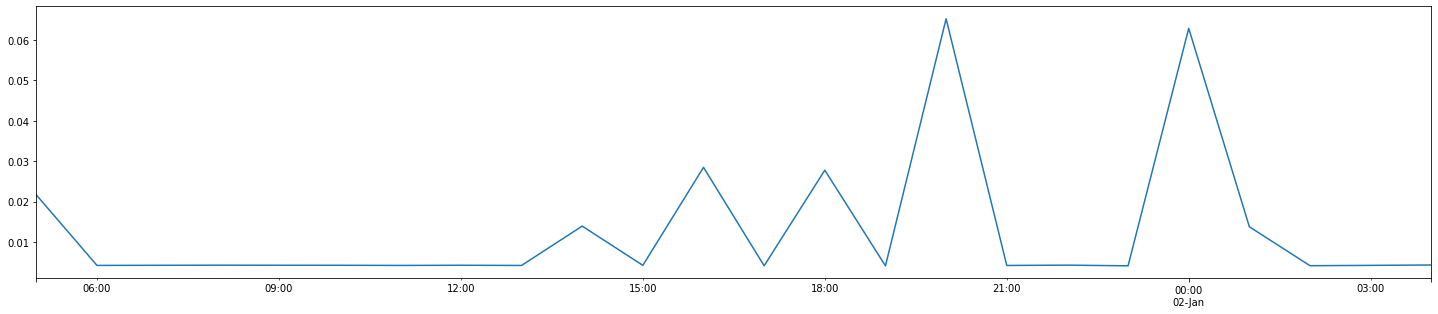

In [ ]:
dataset['Microwave'].resample("h").mean().iloc[:24].plot()

[Text(0.5, 0, 'Daily Hours'), Text(0, 0.5, 'Microwave Usage (kW)')]

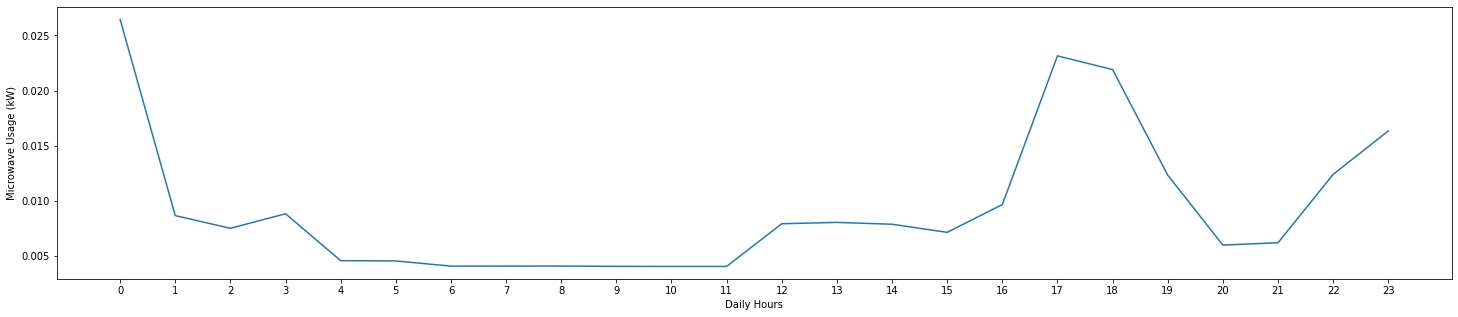

In [ ]:
dataset.groupby(dataset.index.hour).mean()['Microwave'].plot(xticks=np.arange(24)).set(xlabel='Daily Hours', ylabel='Microwave Usage (kW)')

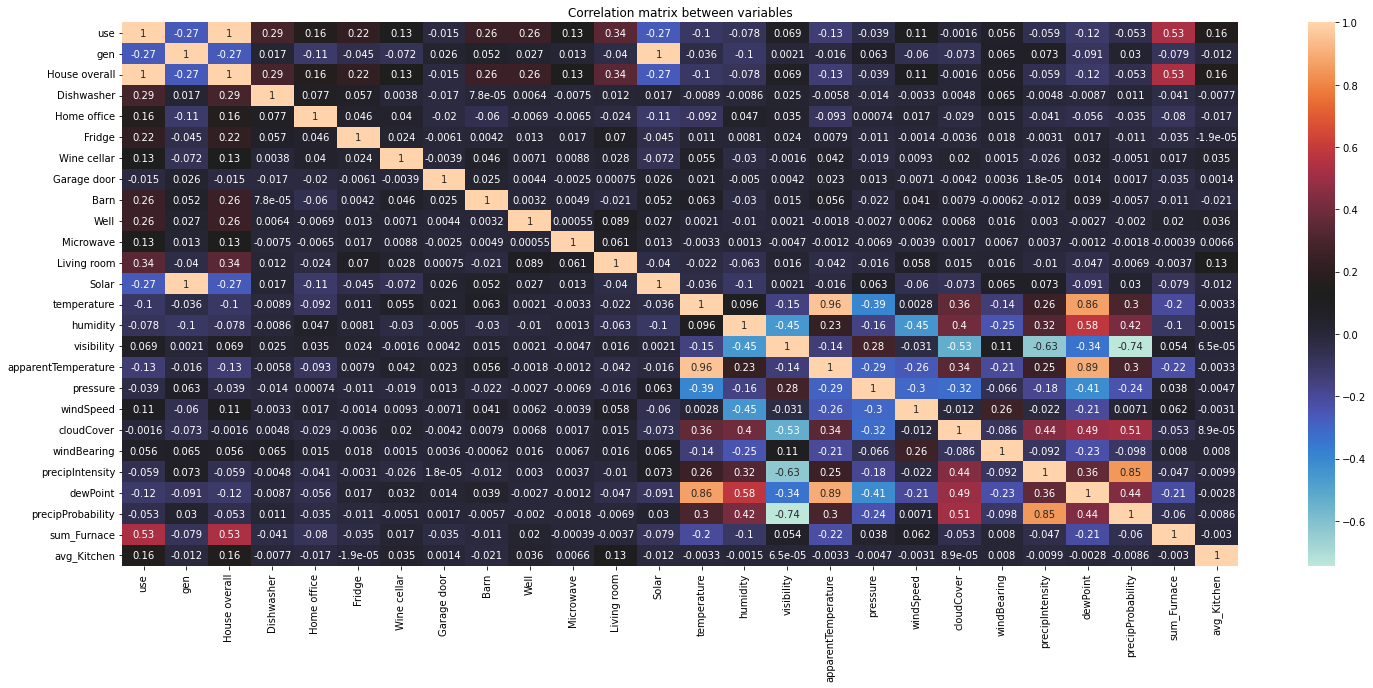

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(dataset.corr(), annot=True, cmap='icefire').set_title('Correlation plot')
plt.title('Correlation matrix between variables')
plt.show()

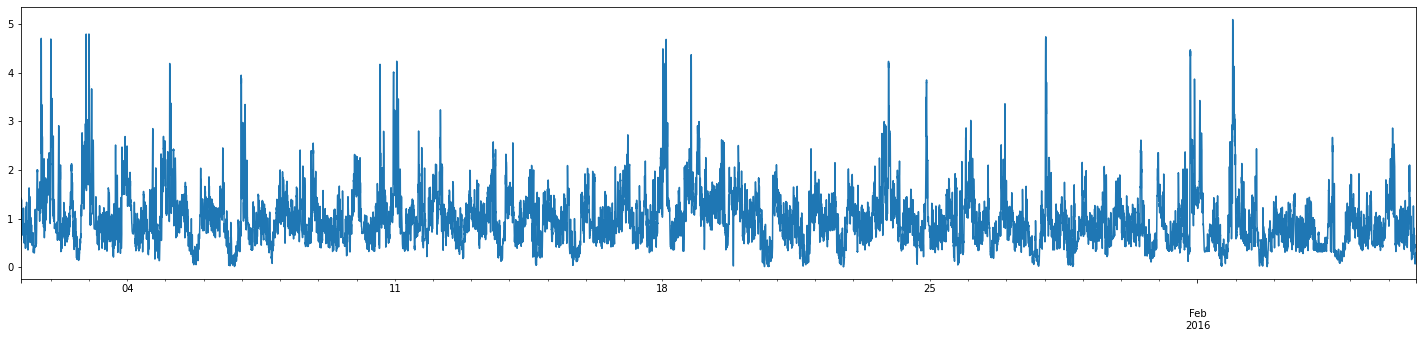

In [ ]:
# Simple Moving Average
dataset['use'] = dataset['use'].rolling(10).mean().plot()

(None, None)

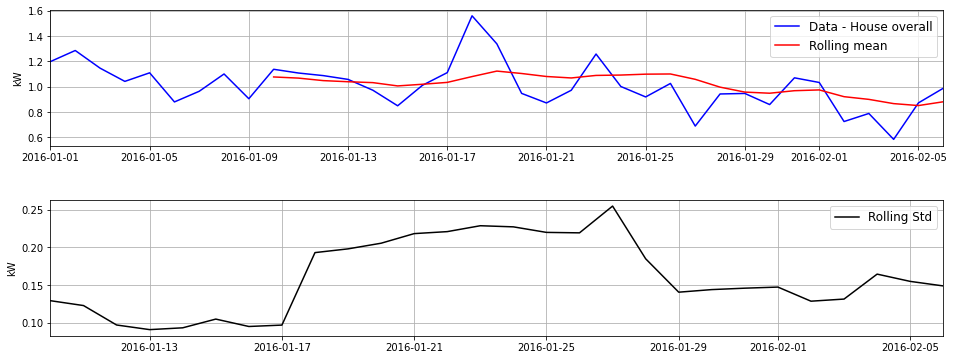

In [ ]:
data_daily = dataset['House overall'].resample('d').mean()
rollingMEAN = data_daily.rolling(window=10).mean()
rollingSTD = data_daily.rolling(window=10).std()
#Plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax1.plot(data_daily, c='blue',label='Data - House overall')
ax1.plot(rollingMEAN, c='red', label='Rolling mean')
ax2.plot(rollingSTD, c='black',label = 'Rolling Std')

ax1.legend(fontsize=12), ax2.legend(fontsize=12)
ax1.set_ylabel('kW'), ax2.set_ylabel('kW')
ax1.margins(x=0), ax2.margins(x=0)
ax1.grid(), ax2.grid()

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultDFtest = adfuller(data_daily, autolag='AIC')
Out = pd.Series(resultDFtest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key1, value1 in resultDFtest[4].items():
    Out['Critical Value (%s)'%key1] = value1
    
print('DICK-FULLER RESULTS: \n\n{}'.format(Out))

DICK-FULLER RESULTS: 

Test Statistic                 -3.687121
p-value                         0.004298
#Lags Used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [ ]:
size = int(len(data_daily)*0.7)
train = data_daily[:size]
test = data_daily[size:]
print('Number of points in series:', len(data_daily))
print('Number of points in train:', len(train))
print('Number of points in test:', len(test))

Number of points in series: 37
Number of points in train: 25
Number of points in test: 12


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,1,1))
#model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(5,0,1,12))
model_fit = model.fit()
print('Akaike information criterion: ', model_fit.aic)

Akaike information criterion:  -14.049286563834826


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          House overall   No. Observations:                   25
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  11.025
Date:                Sat, 04 Mar 2023   AIC                            -14.049
Time:                        18:24:08   BIC                             -9.337
Sample:                    01-01-2016   HQIC                           -12.799
                         - 01-25-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4758      0.361      1.318      0.187      -0.232       1.183
ar.L2         -0.3718      0.307     -1.213      0.225      -0.973       0.229
ma.L1         -0.9969     10.221     -0.098      0.9

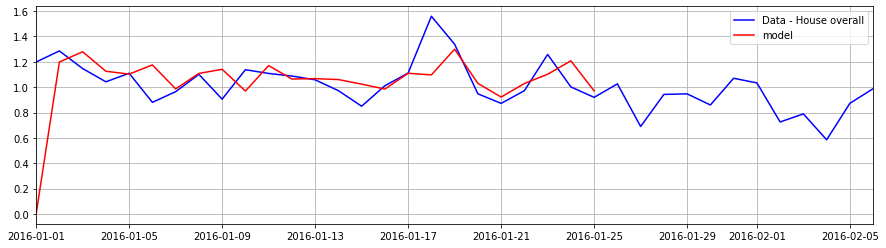

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(data_daily, c='blue',label='Data - House overall')
plt.plot(model_fit.predict(dynamic=False), c='red', label='model')
plt.legend()
plt.grid(), plt.margins(x=0);
print(model_fit.summary())

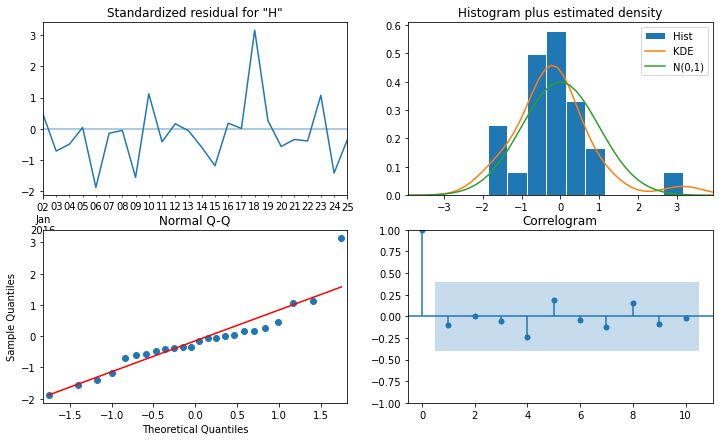

In [ ]:
# Residuals

model_fit.plot_diagnostics(figsize=(12,7))
plt.show()

MSE: 0.062
RMSE: 0.248
MAE: 0.196
MAPE: 0.264
MASE: 1.274
R^2 score: -1.878


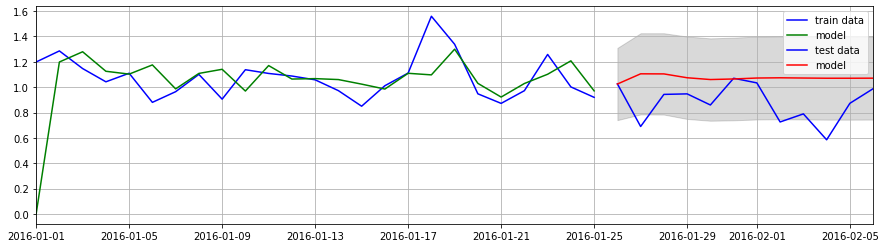

In [ ]:
# from sklearn.metrics import mean_absolute_error,r2_score

# new_fit = model_fit.append(data_daily[size:size+1], refit=False)
# forecast = model_fit.forecast(len(test))
# confidence = model_fit.get_forecast(len(test)).conf_int(0.05)
# #forecast = model_fit.predict(246, 351)
# plt.figure(figsize=(15,4))
# plt.plot(train, c='blue',label='train data')
# plt.plot(model_fit.predict(dynamic=False), c='green', label='model')
# plt.plot(test, c='blue',label='test data')
# plt.plot(forecast, c='red', label='model')
# plt.fill_between(confidence.index,confidence['lower House overall'],
#                  confidence['upper House overall'], color='k', alpha=.15)
# plt.legend()
# plt.grid(), plt.margins(x=0);
# # calcolo errore
# print('MSE: %.3f' % (mean_squared_error(test, forecast)))
# print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, forecast)))
# MAE = mean_absolute_error(test, forecast)
# MAPE = np.mean(np.abs(forecast - test)/np.abs(test))
# MASE = np.mean(np.abs(test - forecast))/(np.abs(np.diff(train)).sum()/(len(train)-1))
# print('MAE: %.3f' % MAE)
# print('MAPE: %.3f' %MAPE)
# print('MASE: %.3f' %MASE)
# print('R^2 score: %.3f' % r2_score(test, forecast))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecast = model_fit.forecast(len(test))
confidence = model_fit.get_forecast(len(test)).conf_int(0.05)
lower_bound = confidence.iloc[:, 0]
upper_bound = confidence.iloc[:, 1]

plt.figure(figsize=(15,4))
plt.plot(train, c='blue',label='train data')
plt.plot(model_fit.predict(dynamic=False), c='green', label='model')
plt.plot(test, c='blue',label='test data')
plt.plot(forecast, c='red', label='model')
plt.fill_between(test.index, lower_bound, upper_bound, color='k', alpha=.15)
plt.legend()
plt.grid()
plt.margins(x=0)

# calcolo errore
print('MSE: %.3f' % (mean_squared_error(test, forecast)))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(test, forecast)))
MAE = mean_absolute_error(test, forecast)
MAPE = np.mean(np.abs(forecast - test)/np.abs(test))
MASE = np.mean(np.abs(test - forecast))/(np.abs(np.diff(train)).sum()/(len(train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(test, forecast))


In [ ]:
import joblib

# Save the trained model as a pickle file
joblib.dump(model, 'model.pkl')

['model.pkl']

In [ ]:
# import pickle
# import numpy as np
# import statsmodels.api as sm
# import joblib

# # Load the trained model from the `model.pkl` file
# joblib.load('model.pkl')

# # Determine the length of time series you want to create
# num_time_steps = 1000

# # Generate a set of random inputs
# random_inputs = np.random.normal(loc=0, scale=1, size=num_time_steps)

# # Use the trained ARIMA model to generate synthetic time series
# synthetic_time_series = model.predict(random_inputs)

# # Combine the random inputs and synthetic time series to create a synthetic time series dataset
# synthetic_data = np.column_stack((random_inputs, synthetic_time_series))


In [ ]:
# import numpy as np
# import pmdarima as pm
# import joblib
# import matplotlib.pyplot as plt

# # Load the dumped ARIMA model
# arima_model = joblib.load("arima_model.pkl")

# # Generate synthetic data using the dumped ARIMA model
# data = arima_model.generate_sample(n_samples=1000)

# # Plot the time series data
# plt.plot(data)
# plt.title("Synthetic Time Series Data")
# plt.show()


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Choose the column to generate synthetic data
data = dataset['Fridge'].values

# Set the ARIMA model parameters
p = 0
d = 1
q = 0

# Generate synthetic data using the ARIMA model
np.random.seed(123)
arima = sm.tsa.ARIMA(data, order=(p, d, q))
arima_fit = arima.fit()
synthetic_data = arima_fit.simulate(nsimulations=20000)

# Save the synthetic data to a CSV file
pd.DataFrame(synthetic_data).to_csv('synthetic_data.csv', index=False)

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


# Choose the columns to generate synthetic data
columns = ['gen', 'House overall', 'Dishwasher']

# Set the ARIMA model parameters
p = 0
d = 1
q = 0

# Generate synthetic data using the ARIMA model
synthetic_data = np.empty((len(dataset), len(columns)))
for i, column in enumerate(columns):
    data = dataset[column].values
    arima = sm.tsa.ARIMA(data, order=(p, d, q))
    arima_fit = arima.fit()
    synthetic_data[:, i] = arima_fit.simulate(nsimulations=len(dataset))

# Save the synthetic data to a CSV file
pd.DataFrame(synthetic_data, columns=columns).to_csv('synthetic.csv', index=False)


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pmdarima as pm


# Choose the columns to generate synthetic data
columns = ['gen', 'House overall', 'Dishwasher']

# Generate synthetic data using the ARIMA model with optimal parameters
np.random.seed(123)
synthetic_data = np.empty((len(dataset), len(columns)))
for i, column in enumerate(columns):
    data = dataset[column].values
    arima = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True)
    synthetic_data[:, i] = arima.predict(n_periods=len(dataset))

# Save the synthetic data to a CSV file
pd.DataFrame(synthetic_data, columns=columns).to_csv('synthetic_data.csv', index=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-143aeafe5479>", line 14, in <module>
    arima = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True)
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/auto.py", line 701, in auto_arima
    sorted_res = search.solve()
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 397, in solve
    self._do_fit((p + 1, d, q), (P, D, Q, m)):
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 233, in _do_fit
    fit, fit_time, new_ic = self._fit_arima(
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/pmdarima/arima/arima.py", line 603, in

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm


# Choose the columns to generate synthetic data
columns = ['gen', 'House overall', 'Dishwasher']

# Set the ARIMA model parameters
p = 0
d = 1
q = 0

# Generate synthetic data using the ARIMA model
synthetic_data = np.empty((len(dataset), len(columns)))
for i, column in enumerate(columns):
    data = dataset[column].values
    arima = sm.tsa.ARIMA(data, order=(p, d, q))
    arima_fit = arima.fit()
    synthetic_data[:, i] = arima_fit.simulate(nsimulations=len(dataset))

# Normalize the synthetic data
scaler = MinMaxScaler()
synthetic_data_norm = scaler.fit_transform(synthetic_data)

# Save the normalized synthetic data to a CSV file
pd.DataFrame(synthetic_data_norm, columns=columns).to_csv('synthetic_norm.csv', index=False)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm


# Choose the columns to generate synthetic data
columns = ['gen', 'House overall', 'Dishwasher']

# Generate synthetic data using auto ARIMA
synthetic_data = np.empty((len(dataset), len(columns)))
for i, column in enumerate(columns):
    data = dataset[column].values
    arima_model = pm.auto_arima(data, suppress_warnings=True)
    synthetic_data[:, i] = arima_model.predict(n_periods=len(dataset))

# Normalize the synthetic data
scaler = MinMaxScaler()
synthetic_data_norm = scaler.fit_transform(synthetic_data)

# Save the normalized synthetic data to a CSV file
pd.DataFrame(synthetic_data_norm, columns=columns).to_csv('synthetic_norm_auto.csv', index=False)
